#### IF we want to import data from database (from IN_PART_R)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#Importing Libraries and estalbishing connectuon to database
import pandas as pd
import numpy as np
import cx_Oracle as cxo
import sqldf
from scipy.stats import t
from scipy import stats
conn = cxo.connect("GIS_IN","GIS_IN", "172.29.10.10:1521/GISIN")
print(conn.version)

#this is the forecasted dataset
df = pd.read_sql("select * from IN_PART_R where company_code='95004-KR1' order by 1,2", con=conn)

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#Importing Libraries and estalbishing connectuon to database
import pandas as pd
import numpy as np
import cx_Oracle as cxo
import sqldf
from scipy.stats import t
from datetime import datetime as dt
from scipy import stats
conn = cxo.connect("GIS_IN","GIS_IN", "172.29.10.10:1521/GISIN")
print(conn.version)

start_time = dt.today()
print('\nSTART TIME : ', start_time.time(),'\n')

df2 = pd.read_sql("select * from IN_PART_R where company_code='95004-KR1' and PART_NO = '25A-AR40-04-B' order by 1,2", con=conn)
df2 = df2[['PERIOD','PART_NO','QTY']]

#Filling the NaN values through K-Nearest Neighbors algorithm
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 4, weights = "uniform")
df2['QTY'] = imputer.fit_transform(df2[['QTY']])

df2['PERIOD'] = pd.to_datetime(df2['PERIOD'], format= '%Y%m')

def DEEPAR(df):
    from gluonts.dataset.common import ListDataset
    from gluonts.model.deepar import DeepAREstimator
    from gluonts.mx.trainer import Trainer
    import numpy as np
    from sklearn.impute import KNNImputer
    PART_N = list(df['PART_NO'].unique())
    a = pd.DataFrame()
    for i in range(0,len(PART_N)):
        print(i)
        data = df[df['PART_NO'] == PART_N[i]]
        #data['PERIOD'] = pd.to_datetime(data['PERIOD'], format= '%Y%m')
        data = data[['PERIOD','QTY']]
        data = data[:24]
        imputer = KNNImputer(n_neighbors = 4, weights = "uniform")
        data['QTY'] = imputer.fit_transform(data[['QTY']])
        data.set_index('PERIOD',inplace= True)
        estimator = DeepAREstimator(freq = 'M',
                                    prediction_length = 12,
                                    num_layers = 2,
                                    num_cells = 50,
                                    cell_type = 'lstm',
                                    trainer = Trainer(epochs = 10))
        training_data = ListDataset(
                                [{"start": data.index[0], "target" : data.QTY}],freq = 'M')
        predictor = estimator.train(training_data = training_data)
        prediction = next(predictor.predict(training_data))
        forecast = list(prediction.mean)
        df_new = pd.DataFrame()
        df_new['QTY'] = forecast
        df_new['PERIOD'] = prediction.index
        df_new['PART_NO'] = PART_N[i]
        df_new = df_new[['PERIOD','PART_NO','QTY']] 
        a = pd.concat([a,df_new])
    return a



output = DEEPAR(df2)

  
end_time = dt.today()
print('\n\nEND TIME : ', end_time.time())
print('\nTOTAL SCRIPT RUNTIME : ', (end_time-start_time))

12.1.0.2.0

START TIME :  09:10:07.733004 



  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.58it/s, epoch=10/10, avg_epoch_loss=2.63]




END TIME :  09:11:34.083977

TOTAL SCRIPT RUNTIME :  0:01:26.350973


MAPE 0.5401322935292638
MAE 18.857820935738392
MSE 609.4207411441231


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


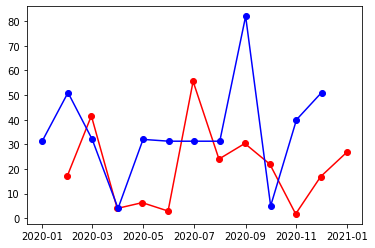

In [2]:
from sklearn.metrics import mean_absolute_percentage_error
import sklearn.metrics as metrics


Predicted = output[['PERIOD','QTY']]
Predicted.set_index('PERIOD',inplace = True)
Predicted['QTY'] = abs(Predicted['QTY'])
Actual = df2[['PERIOD','QTY']].iloc[24:]
Actual.set_index('PERIOD',inplace = True)

MAPE = mean_absolute_percentage_error(Actual.QTY, Predicted.QTY)
mae = metrics.mean_absolute_error(Actual.QTY, Predicted.QTY)
mse = metrics.mean_squared_error(Actual.QTY, Predicted.QTY)

print('MAPE',MAPE)
print('MAE',mae)
print('MSE',mse)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(Predicted,marker = 'o',color = 'red')
plt.plot(Actual,marker = 'o',color = 'blue')

In [ ]:
#### IF WE WANT TO RUN GLUONTS FOR ALL PARTS IN LOOPS we can use below code

In [ ]:
def DEEPAR(df):
    from gluonts.dataset.common import ListDataset
    from gluonts.model.deepar import DeepAREstimator
    from gluonts.mx.trainer import Trainer
    import numpy as np
    import rpy2.robjects as robjects
    # import R packages
    from rpy2.robjects.packages import importr
    PART_N = list(df['PART_NO'].unique())
    a = pd.DataFrame()
    imputeTS = importr('imputeTS') 
    kalman_StructTs = robjects.r['na.kalman']
    kalman_auto_arima = robjects.r['na.kalman']
    for i in range(0,len(PART_N)):
        print(i)
        data = df[df['PART_NO'] == PART_N[i]]
        data['PERIOD'] = pd.to_datetime(data['PERIOD'], format= '%Y%m')
        data = data[['PERIOD','QTY']]
        this_value = np.ndarray.tolist(data['QTY'].values)
        this_value = robjects.FloatVector(this_value)
        data['QTY'] = kalman_StructTs(this_value, model = "StructTS")
        data.set_index('PERIOD',inplace= True)
        estimator = DeepAREstimator(freq = 'M',
                                    prediction_length = 12,
                                    num_layers = 2,
                                    num_cells = 128,
                                    cell_type = 'lstm',
                                    trainer = Trainer(epochs = 20))
        training_data = ListDataset(
                                [{"start": data.index[0], "target" : data.QTY}],freq = 'M')
        predictor = estimator.train(training_data = training_data)
        prediction = next(predictor.predict(training_data))
        forecast = list(prediction.mean)
        df_new = pd.DataFrame()
        df_new['QTY'] = forecast
        df_new['PERIOD'] = prediction.index
        df_new['PART_NO'] = PART_N[i]
        df_new = df_new[['PERIOD','PART_NO','QTY']] 
        a = pd.concat([a,df_new])
    a.to_csv(r'C:/Users/SMC ANALYTICS 1/Desktop/SANDEEP/Time Sales Forecasting/GLUONTS_DEEPAR_B.csv', index = False)